## NIBRS Michigan and Collegiate Baseline Analysis ##

In this notebook, we'll work through some EDA of the NIBRS data for the State and campuses before combining with sports data to see what kinds of patterns exist.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from matplotlib.dates import DateFormatter

As the data is quite large, We're using spark to assist with getting the dataset to a reasonable size.  

In [15]:
from pyspark.sql.types import DateType
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName('NIBRS') \
    .getOrCreate() 

sc = spark.sparkContext

There are 4 data files that we'll be using to combine into a dataset that can be paired with the college and football data.

In [115]:
inc = spark.read.csv('../01_nibrs_rawdata/Combined_Incidents.csv',header=True, inferSchema=True)
off = spark.read.csv('../../Project/Data/NIBRS_OFFENSES.csv', header=True, inferSchema=True)
ag = spark.read.csv('../01_nibrs_rawdata/agencies.csv', header=True, inferSchema=True)
offtype = spark.read.csv('../01_nibrs_rawdata/NIBRS_OFFENSE_TYPE.csv',header=True, inferSchema=True)

In [116]:
ag.columns

['AGENCY_ID', 'YEAR', 'AGENCY_NAME', 'COUNTY', 'TYPE']

In [117]:
# Let's take a look at the columns and data types that exist in all of the Spark DataFrames

print("Incidents", inc.dtypes)
print("Offences", off.dtypes)
print("Agencies", ag.dtypes)
print("Offense Types", offtype.dtypes)

Incidents [('DATA_YEAR', 'int'), ('AGENCY_ID', 'int'), ('INCIDENT_ID', 'int'), ('INCIDENT_DATE', 'string'), ('INCIDENT_HOUR', 'double')]
Offences [('YEAR', 'int'), ('OFFENSE_ID', 'int'), ('INCIDENT_ID', 'int'), ('OFFENSE_TYPE_ID', 'int')]
Agencies [('AGENCY_ID', 'string'), ('YEAR', 'string'), ('AGENCY_NAME', 'string'), ('COUNTY', 'string'), ('TYPE', 'string')]
Offense Types [('OFFENSE_TYPE_ID', 'int'), ('OFFENSE_CODE', 'string'), ('OFFENSE_NAME', 'string'), ('CRIME_AGAINST', 'string'), ('CT_FLAG', 'string'), ('HC_FLAG', 'string'), ('HC_CODE', 'int'), ('OFFENSE_CATEGORY_NAME', 'string'), ('OFFENSE_GROUP', 'string')]


In [118]:
# One of the biggest issues right off the bat is that the column for incident_date - a critical column - doesn't register as a date data type. 
inc = inc.withColumn('INCIDENT_DATE',col('INCIDENT_DATE').cast(DateType()))

In [119]:
# Let's create aliases/views of the dataframes so that we can use SQL to pull the data together.

inc.createOrReplaceTempView("inc")
off.createOrReplaceTempView("off")
ag.createOrReplaceTempView("ag")
offtype.createOrReplaceTempView('offtype')

### Michigan-Level Incident Analysis ###

Now that the data is in tables, we can use SQL to provide a more manageable dataset.  Let's look at the incidents across the State of Michigan over the 10-year period, looking at things like seasonality.

In [7]:
query = """

SELECT INCIDENT_DATE, COUNT(INCIDENT_ID) as INCIDENT_COUNT
FROM inc
GROUP BY INCIDENT_DATE
"""


result = spark.sql(query)


In [8]:
inc_cnt = result.toPandas()

I've creaeted a pandas dataframe from the result (a PySpark DataFrame).  The dataframe contains an aggregation of the number of incidents by date. 

In [9]:
inc_cnt.head()

,INCIDENT_DATE,INCIDENT_COUNT
0,2013-01-22,1107
1,2013-03-26,1484
2,2013-05-21,1633
3,2013-09-09,1517
4,2013-09-19,1504


In [10]:
inc_cnt.describe()

,INCIDENT_COUNT
count,3652.000000
mean,1392.749726
std,237.056614
min,576.000000
25%,1233.000000
50%,1389.000000
75%,1543.000000
max,2256.000000


On average, there are almost 1400 incidents reported across the state. Let's see if we see any trends over the 10 years

<AxesSubplot:title={'center':'Number of Incidents by Date (2010-2019) for Michigan'}, xlabel='INCIDENT_DATE'>

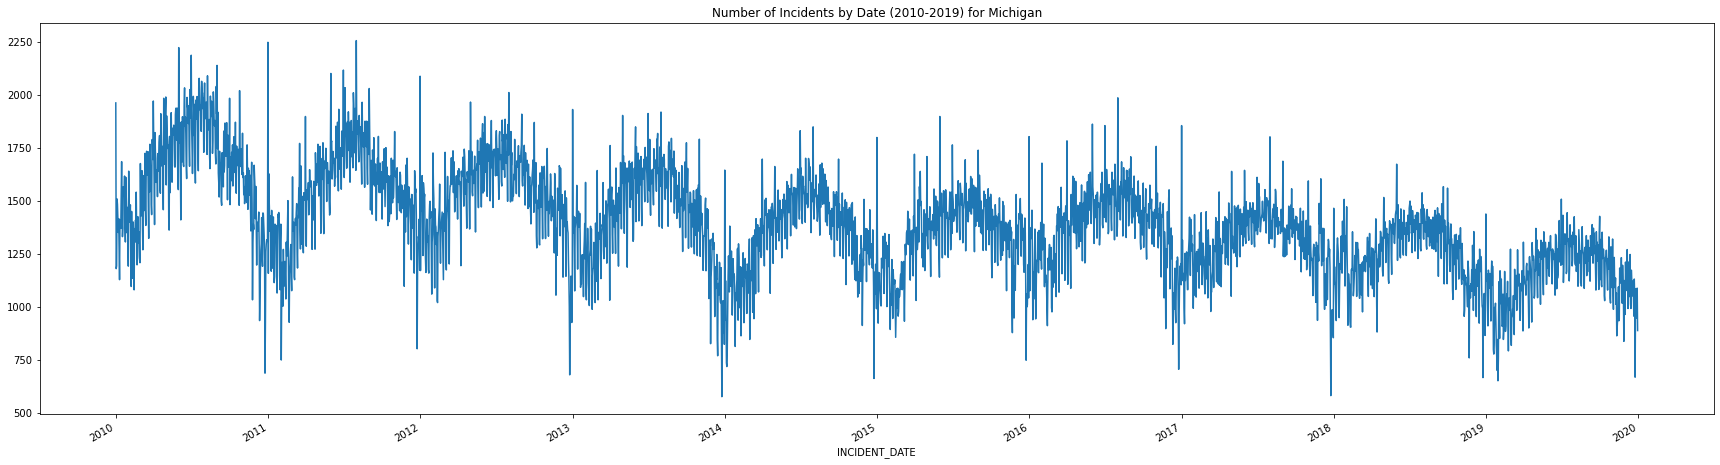

In [11]:
# We need to convert the incident date to a pandas datetime. In order for us to do a time-series, we need to change the dataframe to use a timeseries index
inc_cnt['INCIDENT_DATE'] = pd.to_datetime(inc_cnt['INCIDENT_DATE'])
inc_date = inc_cnt.set_index('INCIDENT_DATE')

fig, ax = plt.subplots(1)

inc_date.plot(figsize=(30,8), ax=ax, 
title="Number of Incidents by Date (2010-2019) for Michigan",legend=False)

Very interesting! We see a couple things going on here.  The first is that there appears to be a valley at the beginning of eacu year (corresponding to colder months) and peaks in the middle or near-middle of each year (warmer months).  The second observation is that there is an overall trend of decreasing incidents.  We can run descriptive statistics by year to validate that this is accurate as well as resample the times to make it a little easier (smoother) to see.

In [12]:
# Here I'm going to create a mini-datafrae that uses the datetime accessor to retrieve the year from the Incident Date and obtain descriptive statistics off the years.
years_desc = inc_cnt.groupby(inc_cnt['INCIDENT_DATE'].dt.year).describe().reset_index()
years_desc

INCIDENT_DATE INCIDENT_COUNT                                           \
                         count         mean         std    min      25%   
0          2010          365.0  1636.178082  243.349020  687.0  1460.00   
1          2011          365.0  1546.367123  229.530211  749.0  1421.00   
2          2012          366.0  1537.122951  195.568602  679.0  1440.25   
3          2013          365.0  1432.545205  220.625699  576.0  1303.00   
4          2014          365.0  1348.021918  196.079191  662.0  1228.00   
5          2015          365.0  1335.745205  173.696000  748.0  1230.00   
6          2016          366.0  1379.773224  179.784393  705.0  1278.50   
7          2017          365.0  1307.895890  152.827113  581.0  1230.00   
8          2018          365.0  1255.367123  146.630177  666.0  1170.00   
9          2019          365.0  1148.120548  147.050495  651.0  1055.00   

                            
      50%      75%     max  
0  1659.0  1810.00  2223.0  
1  1569.0  1689.00  2256.0  
2  1564.0  1668.00  2088.0  
3  1451.0  1606.00  1931.0  
4  1381.0  1488.00  1849.0  
5  1361.0  1449.00  1898.0  
6  1405.0  1499.75  1986.0  
7  1322.0  1407.00  1855.0  
8  1272.0  1360.00  1673.0  
9  1157.0  1262.00  1508.0

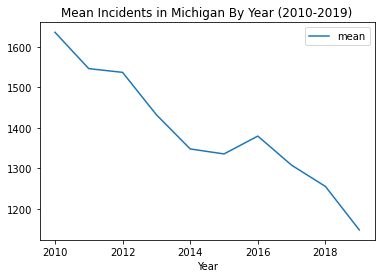

In [13]:
# We'll run a simple line graph (as a picture has less cognitive load compared to interpreting raw numbers)
years_desc.columns= ['Year', 'count','mean','std','min','25%','50%','75%','max']
years_desc.plot(x='Year', y='mean', title='Mean Incidents in Michigan By Year (2010-2019)');

Here - it's a little easier to see the downward trend.  There does appear to be a bit of an increase in 2011 and also in 2016 but generally the trend is downward. Though we have the gist of the direction and cyclical nature of the incidences, we can make it easier to see the peaks and vallesy by using resampled data.  We'll create the lineplot by resampling incident counts over a month's length and summing the data which should reduce the exccess noise that we saw from mapping every date.

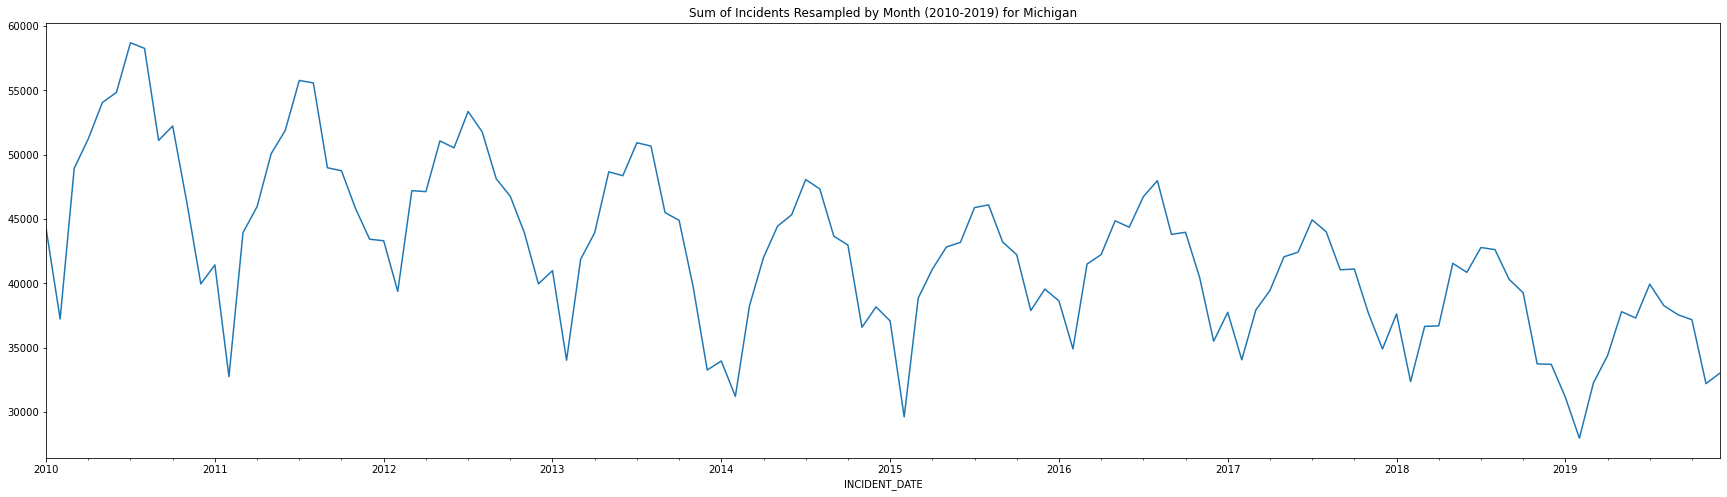

In [15]:
fig, ax = plt.subplots(1, sharex=True)

inc_date.resample('1M').sum().plot(figsize=(30,8), ax=ax, 
title="Sum of Incidents Resampled by Month (2010-2019) for Michigan",legend=False);

### Seasonality of Offenses ###

We're going to split the months up into categories relating to the 4 Seasons.  This isn't exact but anything that falls into the first 3 months of the year will be considered Winter, the next 3 will be Spring, next 3 Summer and so on.  

In [16]:
inc_date['Season'] = pd.cut(inc_date.index.month, bins=[0,3,6,9,12], labels=['Winter','Spring','Summer','Fall'])

In [17]:
inc_date.groupby('Season').describe()

INCIDENT_COUNT                                                    \
                count         mean         std     min      25%     50%   
Season                                                                    
Winter          902.0  1249.620843  202.776352   651.0  1116.00  1237.5   
Spring          910.0  1473.308791  204.407653   881.0  1333.00  1457.0   
Summer          920.0  1536.066304  202.783409  1079.0  1394.00  1512.5   
Fall            920.0  1310.078261  215.767624   576.0  1172.75  1318.0   

                         
            75%     max  
Season                   
Winter  1378.00  2248.0  
Spring  1615.50  2223.0  
Summer  1665.25  2256.0  
Fall    1459.00  2020.0

Interpretation: Counts here present the dates that we're counting.  The Mean represents the average number of crimes across the respective seasons over the 10 years and clearly shows what the graphs were telling us - that Summer experiences a higher number of incidents on average than the other months (with Spring coming in second followed by Fall).  This will need to be comprehended in our analysis of the effect on Crime as spring and summer sports. One caveat is that Football games start in the summer (in this case September). Let's see if we can understand what crimes are committed by Season by incorporating the associated offenses.

In [18]:
query1 = """

SELECT
i.INCIDENT_DATE, i.INCIDENT_ID, i.AGENCY_ID, ot.NAME

FROM
 inc i,
 off o,
 offtype ot
 
 
WHERE
o.INCIDENT_ID = i.INCIDENT_ID AND
o.OFFENSE_TYPE_ID = ot.OFFENSE_TYPE_ID

"""

result1 = spark.sql(query1)

### Baseline Analysis of Michigan/Michigan State Incidents ###

Now that we have an idea of what crime looks like in the State of Michigan, let's zoom into the two campuses.  Here, we don't want to talk about the sports events just yet, we want to understand what crime looks like across the two campuses. We can attribute which incident occurred for which campus by using the Agency ID as a proxy.  There are two primary agencies we'll be looking at: 9040 and 8554 for Michigan and Michigan State, respectively.


In [16]:
query2 = """

SELECT
INCIDENT_DATE, AGENCY_ID, COUNT(INCIDENT_ID) As INCIDENT_COUNTS

FROM
 inc i
 
WHERE
AGENCY_ID IN (9040,8554)

GROUP BY
    INCIDENT_DATE, AGENCY_ID
"""

result2 = spark.sql(query2)


In [30]:
uni_incs = result2.toPandas()

In [31]:
uni_incs.shape

(6427, 3)

In [32]:
uni_incs['INCIDENT_DATE'] = pd.to_datetime(uni_incs["INCIDENT_DATE"])
uni_inc_dates = uni_incs.set_index('INCIDENT_DATE')

In [33]:
uni_inc_dates.columns = ['AGENCY_ID','INCIDENT_COUNTS']
uni_inc_dates = uni_inc_dates.groupby([uni_inc_dates.index, 'AGENCY_ID'])[['INCIDENT_COUNTS']].sum()

In [34]:
# uni_inc_dates[uni_inc_dates.index.day_of_week==5][['MSU','UMICH']].sort_values('UMICH', ascending=False)

In [35]:
uni_inc_dates.head()

INCIDENT_COUNTS
INCIDENT_DATE AGENCY_ID                 
2010-01-01    8554                     1
              9040                     6
2010-01-03    8554                     2
              9040                     1
2010-01-04    8554                     1

In [36]:
uni_inc_dates = uni_inc_dates.reset_index()
uni_inc_dates = uni_inc_dates.pivot(index='INCIDENT_DATE', columns='AGENCY_ID')

In [37]:
uni_inc_dates.head()

INCIDENT_COUNTS     
AGENCY_ID                8554 9040
INCIDENT_DATE                     
2010-01-01                1.0  6.0
2010-01-03                2.0  1.0
2010-01-04                1.0  NaN
2010-01-05                1.0  6.0
2010-01-06                1.0  5.0

In [38]:
uni_inc_dates.columns = ['MSU','UMICH']

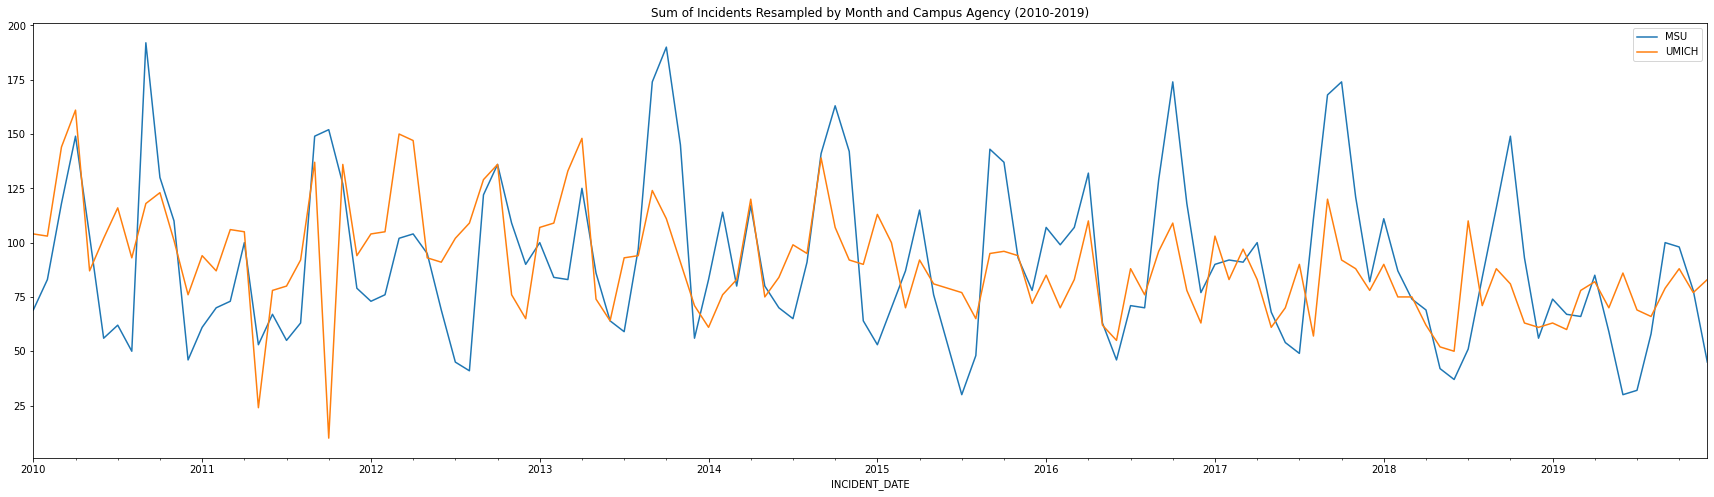

In [39]:
# fig, ax = plt.subplots(1, sharex=True)
uni_inc_dates.resample('1M').sum().plot(figsize=(30,8),

# uni_incs[['INCIDENT_COUNTS'].plot(figsize=(30,8), ax=ax, 
title="Sum of Incidents Resampled by Month and Campus Agency (2010-2019)",legend=True);

Here we see the number of incidences across the 10 years downsampled over each month and how they move.  We can see valleys forming in the middle of the year for MSU (spring/summer) and then very pronounced peaks in incidents in the fall which seem to correspond to Fall Semester. It appears there is a large drop near the beginning of the year (semester break and into the colder months).

Michigan doesn't show quite the same pattern nor the exaggerated peaks and falls in the data (sans a significant drop-off in late 2011). We could say on average there appears to be less variability in the number of incidents for Michigan compared to Michigan State.

Let's take a closer look at the offenses involved with each incident as that will tell us what kind of crimes were being committed.

In [171]:
sql = """

SELECT i.INCIDENT_DATE, CAST(i.INCIDENT_HOUR AS INT), i.INCIDENT_ID, ot.OFFENSE_NAME, i.AGENCY_ID


FROM 
    inc i,
    off o,
    ag a,
    offtype ot
    
WHERE
    o.INCIDENT_ID = i.INCIDENT_ID AND
    i.AGENCY_ID = a.AGENCY_ID AND
    o.OFFENSE_TYPE_ID = ot.OFFENSE_TYPE_ID AND
    i.AGENCY_ID IN (9040, 8554)
    
"""
result3 = spark.sql(sql)


In [172]:
offs = result3.toPandas()

In [173]:
offs.sample(20)

,INCIDENT_DATE,INCIDENT_HOUR,INCIDENT_ID,OFFENSE_NAME,AGENCY_ID
4604,2014-04-04,1,74951705,Drug/Narcotic Violations,9040
9864,2019-11-21,21,118822924,Theft From Building,8554
239,2013-12-24,17,69064489,Destruction/Damage/Vandalism of Property,9040
17572,2011-04-06,16,60145758,Destruction/Damage/Vandalism of Property,8554
819,2013-04-28,22,69059063,Shoplifting,9040
11042,2019-04-06,12,114291048,Fondling,9040
18350,2016-04-02,15,86419952,Drug/Narcotic Violations,9040
1535,2013-10-12,12,68584573,All Other Larceny,8554
18000,2011-01-15,18,60144762,Simple Assault,8554
11413,2017-02-17,15,100251940,Drug/Narcotic Violations,8554


In [174]:
offs['INCIDENT_HOUR'] = offs['INCIDENT_HOUR'].astype('str') + ":00:00"


In [175]:
offs['INCIDENT_DATE']

0        2013-01-10
1        2013-02-08
2        2013-03-07
3        2013-05-29
4        2013-05-28
            ...    
22697    2018-05-29
22698    2018-10-02
22699    2018-11-15
22700    2018-03-16
22701    2018-10-08
Name: INCIDENT_DATE, Length: 22702, dtype: object

In [176]:
offs['INCIDENT_DATE'] = pd.to_datetime(offs['INCIDENT_DATE'].astype('str') + ' ' + offs['INCIDENT_HOUR'])

In [177]:
offs['Day'] = offs['INCIDENT_DATE'].dt.dayofweek

In [178]:
offs['School'] = offs['AGENCY_ID'].apply(lambda x: "michigan" if x==9040 else "michigan state")

In [179]:
offs.groupby('School')[['OFFENSE_NAME']].count()

,OFFENSE_NAME
School,
michigan,11199
michigan state,11503


Here we obtained the number of offenses (for which there may be one or more for a specific incidence).  It appears that MSU has a higer number but not by much.  Let's evaluate what the top offenses are by school using barcharts:

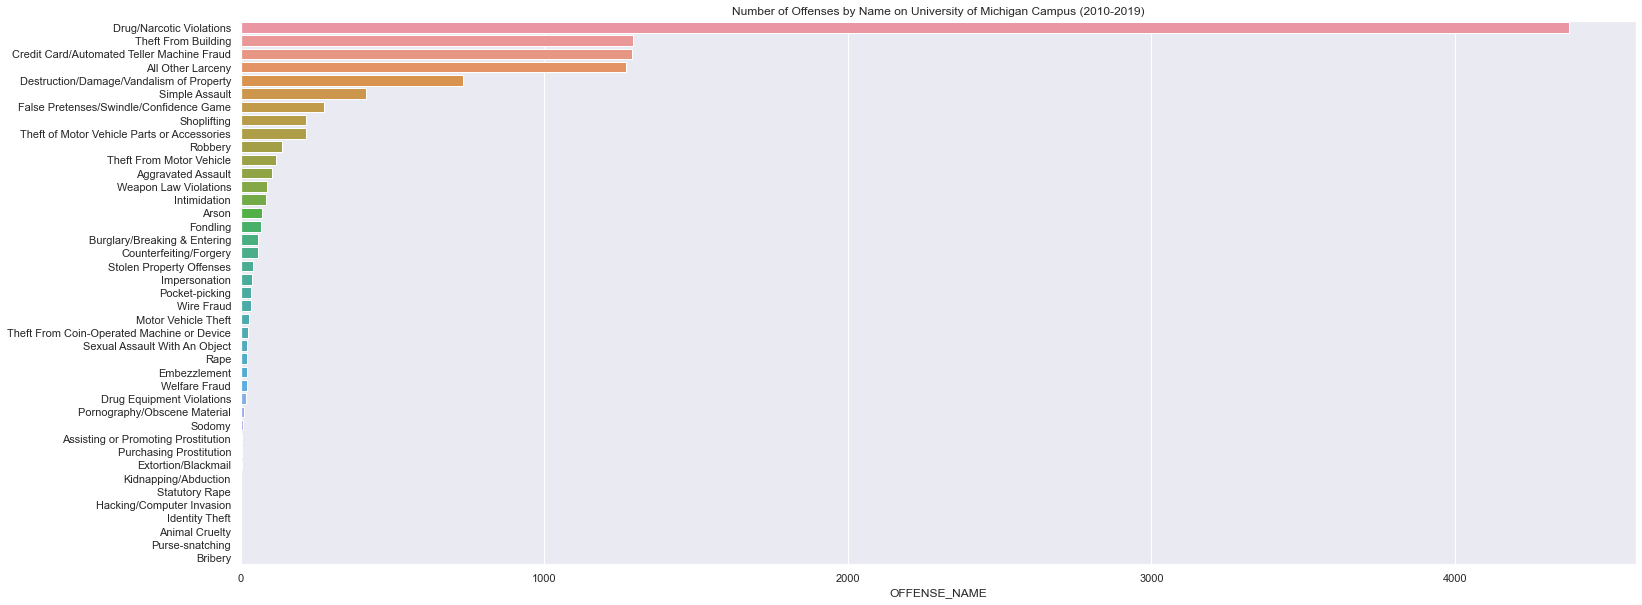

In [180]:

um = offs[offs['AGENCY_ID']==9040]
sns.barplot(x= um.OFFENSE_NAME.value_counts(), y=um.OFFENSE_NAME.unique()).set(title='Number of Offenses by Name on University of Michigan Campus (2010-2019)')
sns.set(rc={"figure.figsize":(25, 10)})


We can see that across the 10 years, 'Drug/Narcotic Violations" is the biggest offense on U-M's campus by a large margin. NIBRS documentation defines this offense as 'The unlawful cultivation, manufacture, distribution, sale, purchase, use, possession, transportation, or importation of any controlled drug or narcotic substance.'  This seems to be appropriate especially since we're dealing with a college campus.   Also to clarify, this is not including Driving Under Influence.  Looking down the list, we see a large number of instances related to theft, credit card fraud and All Other Larceny which is small thefts. After that, there is a bit of a drop-off in incidence frequency but see Destruction of Property and Simple Assault finishing up the top 6.

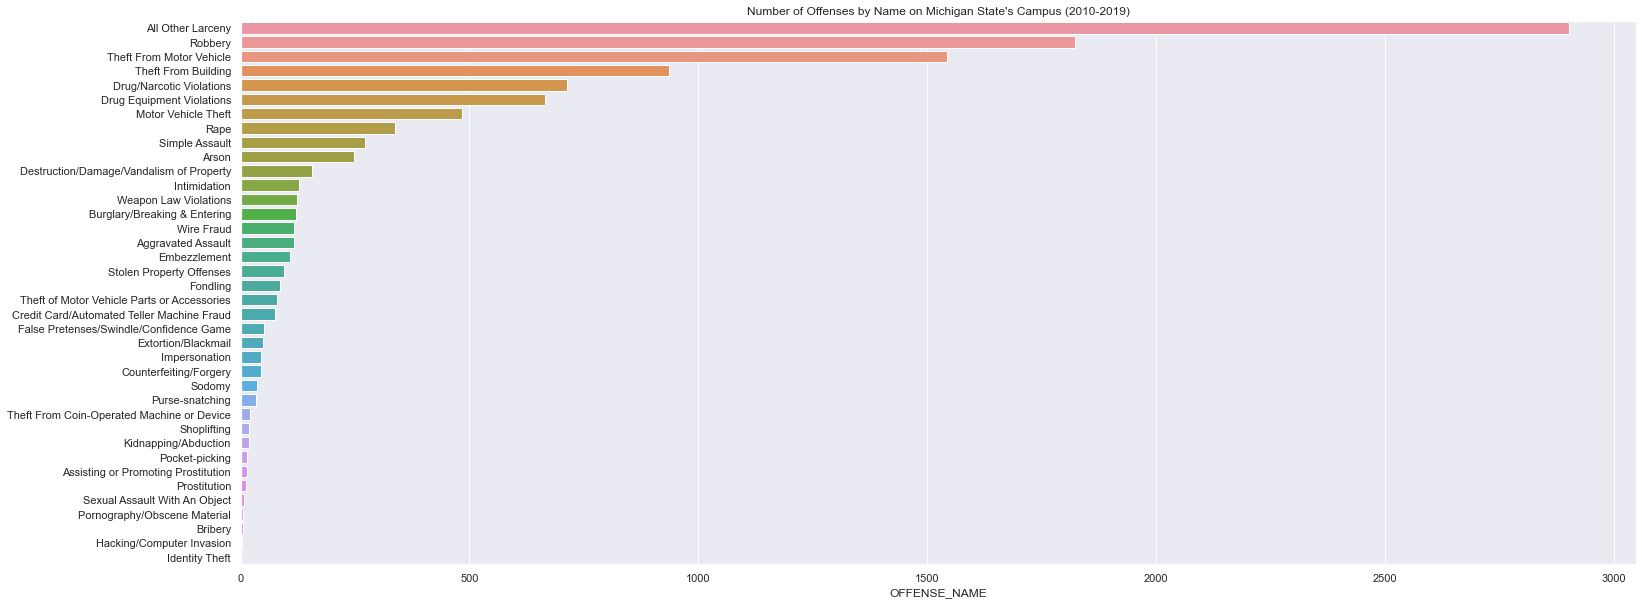

In [181]:
msu= offs[offs['AGENCY_ID']==8554]
sns.barplot(x= msu.OFFENSE_NAME.value_counts(), y=msu.OFFENSE_NAME.unique()).set(title='Number of Offenses by Name on Michigan State\'s Campus (2010-2019)')
sns.set(rc={"figure.figsize":(25, 10)})

For Michigan State's Campus, we surprisingly see less frequency of Drug/Narcotic Violations (even though we've always heard MSU can be a party school) which is 5th most frequent according to the NIBRS data.  Here, the "All Other Larceny" is at the top by a very large margin.  The definition per the top NIBRS Offense unfortunately defines this as "All thefts which do not fit any of the definitions of the specific subcategories of Larceny/Theft listed" which would exclude Pocket-picking, purse-snatching, shoplifting, theft from building, theft from devices, theft from motor vehicle and theft of vehicle parts/accessories." Looking down the list we see that the top 4 offenses all seem to involve theft.  For each school, let's see what the top 5 offenses are by season:

In [182]:
offs.head()

,INCIDENT_DATE,INCIDENT_HOUR,INCIDENT_ID,OFFENSE_NAME,AGENCY_ID,Day,School
0,2013-01-10 21:00:00,21:00:00,69056266,Drug/Narcotic Violations,9040,3,michigan
1,2013-02-08 12:00:00,12:00:00,69057174,Theft From Building,9040,4,michigan
2,2013-03-07 20:00:00,20:00:00,69058152,Credit Card/Automated Teller Machine Fraud,9040,3,michigan
3,2013-05-29 10:00:00,10:00:00,69059921,All Other Larceny,9040,2,michigan
4,2013-05-28 12:00:00,12:00:00,69060846,Theft From Building,9040,1,michigan


In [185]:
# We're going to use a bit of creativitiy with the exact dates that seasons fall and this is due to the fact that each year has slightly different days the seasons start.


def GetSeason(date):
    dayofyear = date.day_of_year
    if  dayofyear < 79:
        return 'Winter'
    elif dayofyear >= 79 and dayofyear < 172:
        return 'Spring'
    elif dayofyear >= 172 and dayofyear < 264:
        return 'Summer'
    elif dayofyear >= 264 and dayofyear < 355:
        return 'Fall'
    else:
        return 'Winter'
    
offs['SEASON'] = offs['INCIDENT_DATE'].apply(lambda x: GetSeason(x))

    
    
    
    

In [219]:
df_lst = []
for i, test in offs.groupby(['School','SEASON']):
    df_lst.append(test.groupby(['School','SEASON','OFFENSE_NAME'])['INCIDENT_ID'].agg('count').sort_values(ascending=False)[:5].reset_index())

pd.concat(df_lst)

,School,SEASON,OFFENSE_NAME,INCIDENT_ID
0,michigan,Fall,Theft From Building,1148
1,michigan,Fall,Drug/Narcotic Violations,345
2,michigan,Fall,Destruction/Damage/Vandalism of Property,326
3,michigan,Fall,All Other Larceny,292
4,michigan,Fall,Simple Assault,201
0,michigan,Spring,Theft From Building,1131
1,michigan,Spring,All Other Larceny,397
2,michigan,Spring,Destruction/Damage/Vandalism of Property,362
3,michigan,Spring,Drug/Narcotic Violations,300
4,michigan,Spring,Simple Assault,176


In [222]:
offs.to_csv("../01_nibrs_rawdata/UM_MSU_Offs.csv",index=False)

In [71]:
grp_off = offs.groupby(['AGENCY_ID','Day','NAME']).describe().reset_index()

In [41]:
grp_off.columns = ['AGENCY_ID','Day','NAME','count','mean','std','min','25%','50%','75%','max']